# VAE: Theory

**Notation**
* Observed variables $\mathbf{x}\in\mathcal{X}$.
* Unobserved variables $\mathbf{z}\in\mathbb{R}^{k}$.
* Dataset $\mathcal{D}=\{\mathbf{x}_i\}^{n}_{i=1}$

### ELBO
The marginal log-likelihood of the whole dataset $\mathcal{D}$ is given as
$$\log p_\theta(\mathbf{x}_1,...,\mathbf{x}_n)=\log\prod^{n}_{i=1}p_\theta(\mathbf{x}_i)=\sum^{n}_{i=1}\log p_\theta(\mathbf{x}_i)$$
We write the evidence lower bound for each data point $\mathbf{x}_i$ as 
$$ \log p_\theta(\mathbf{x}_i)\geq \mathcal{L}(\mathbf{x}_i,\theta,\phi) = \underbrace{\mathbb{E}_{q_\phi(\mathbf{z}_i\mid\mathbf{x}_i)}\Big[\log p_\theta(\mathbf{x}_i\mid\mathbf{z}_i)\Big]}_{\text{reconstruction error}}-\underbrace{KL\Big(q_\phi(\mathbf{z}_i\mid\mathbf{x}_i)||p_\theta(\mathbf{z}_i)\Big)}_{\text{regularisation}}$$
where 
* $\theta$ are the parameters of the generative model or **decoder** $p_\theta(\mathbf{x}\mid \mathbf{z})$.
* $\phi$ are the variational parameters of the variational distribution $q_\phi(\mathbf{z}\mid\mathbf{x})$, also called the recognition model or **encoder**.

These two terms have interesting interpretations:
* **Reconstruction error:** is the log-likelihood of observed $\mathbf{x}_i$ given the code $\mathbf{z}_i$ that we have sampled $\mathbf{z}_i\sim q_\phi(\mathbf{z}_i\mid\mathbf{x}_i)$. This term is maximised when $p_\theta(\mathbf{x}_i\mid\mathbf{z}_i)$ assigns high probability to the original $\mathbf{x}_i$. It is trying to reconstruct $\mathbf{x}_i$ from $\mathbf{z}_i$.

* **Regularisation:** KL divergence between $q_\phi(\mathbf{z}_i\mid\mathbf{x}_i)$ and prior $p_\theta(\mathbf{z}_i)$. It can be interpretted as regularising $\phi$ by encouraging the approximate posterior $q_\phi(\mathbf{z}_i\mid\mathbf{x}_i)$ to be close to the prior $p_\theta(\mathbf{z}_i)$. This prevents $q_\phi(\mathbf{z}_i\mid\mathbf{x}_i)$ from simply encoding an identity mapping and instead forces it to learn some more interesting representations.

### Model

For our task of using the MNIST dataset where $\mathbf{x}_i\in[0,1]^{784}$, the VAE has the following parameterisations
* The prior over the latent variables as a multivariate standard normal.
$$p_\theta(\mathbf{z})=\mathcal{N}\Big(\mathbf{z};\mathbf{0},\mathbf{I}_k\Big)$$

* The true posterior distribution as an independent Bernoulli for each element $x_j$ of $\mathbf{x}$ (for binary data)$$p_\theta(x_j\mid\mathbf{z})=\text{Ber}\Big(\mu_\theta(\mathbf{z})\Big)$$

* The variational approximate posterior as a multivariate Gaussian
$$q_\phi(\mathbf{z}\mid \mathbf{x})=\mathcal{N}\bigg(\mathbf{z};\boldsymbol{\mu}_\phi(\mathbf{x}), \boldsymbol{\Sigma}_\phi(\mathbf{x})\bigg)$$
where $\boldsymbol{\mu}_\phi(\mathbf{x})\in\mathbb{R}^{k}$ and $\boldsymbol{\Sigma}_\phi(\mathbf{x})=\text{diag}\big(\boldsymbol{\sigma}_\phi^{2}(\mathbf{x})\big)\in\mathbb{R}^{k\times k}$ are parameterised by neural networks with parameters $\phi$.

### Loss Function

By using the **reparameterisation trick** and the specific parameterisation of the distributions given above, the loss function for this model over the whole dataset which we would like to **minimise** is
$$\mathcal{L}(\mathbf{x},\theta,\phi)\approx \frac{1}{n}\sum^{n}_{i=1}\Bigg[\frac{1}{2}\sum^{k}_{j=1}\Big[\mu^{2}_{\phi,j}(\mathbf{x}_i)+\sigma^{2}_{\phi,j}(\mathbf{x}_i)-\log\sigma^{2}_{\phi,j}(\mathbf{x}_i)-1\Big]-\frac{1}{L}\sum^{L}_{l=1}\Big[\log p_\theta(\mathbf{x}_i\mid\mathbf{z}_{i,l})\Big]\Bigg]$$

where $\mathbf{z}_{i,l}=g_\phi\Big(\mathbf{x}_i,\boldsymbol{\epsilon}_{i,l}\Big)=\boldsymbol{\mu}_{\phi}(\mathbf{x}_i)+\boldsymbol{\sigma}_{\phi}(\mathbf{x}_i)\odot \boldsymbol{\epsilon}_{i,l}$ and $\boldsymbol{\epsilon}_{i,l}\sim\mathcal{N}(\mathbf{0},\mathbf{I}_k)$. $L$ is the number of samples to use for the Monte Carlo estimator of the reconstruction error. In practice, we use mini-batches and $L=1$.

By using our parameterisation of the decoder $p_\theta(\mathbf{x}\mid\mathbf{z})$ as a indepenedent Bernoulli we have that 
$$-\log p(\mathbf{x}\mid \mathbf{z})=-\sum^{}_{i=1}\mathbf{x}_i\log \hat{\mathbf{x}}_i + (1-\mathbf{x}_i)\log(1-\hat{\mathbf{x}}_i)$$
i.e. this is the Binary Cross Entropy loss.

### Challenges

### References
Original VAE paper: https://arxiv.org/abs/1312.6114<br>
CS228 notes: https://ermongroup.github.io/cs228-notes/<br>
Yuge Shi blog: https://yugeten.github.io/posts/2020/06/elbo/ <br>
Tutorial paper: https://arxiv.org/abs/1906.02691<br>
CS236 notes: https://deepgenerativemodels.github.io/notes/<br>
Lilian Weng blog: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html


# VAE: Code

PyTorch-VAE: https://github.com/AntixK/PyTorch-VAE<br>
https://github.com/ethanluoyc/pytorch-vae

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

## Load MNIST Dataset

In [2]:
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import MNIST
# # 60000 tuples with 1x28x28 image and corresponding label
# data = MNIST('../data', 
#              train=True, 
#              download=True,
#              transform = transforms.Compose([transforms.ToTensor()]))
# # Split data into images and labels
# x_train = data.train_data
# y_train = data.train_labels
# # Scale images from [0,255] to [0,+1]
# x_train = x_train.float() / 255
# # Save as .npz
# np.savez_compressed('../data/mnist', 
#                     a=x_train,
#                     b=y_train)

In [3]:
# Load MNIST data locally
data = np.load('../data/mnist.npz')
x_train = torch.Tensor(data['a'])
y_train = torch.Tensor(data['b'])

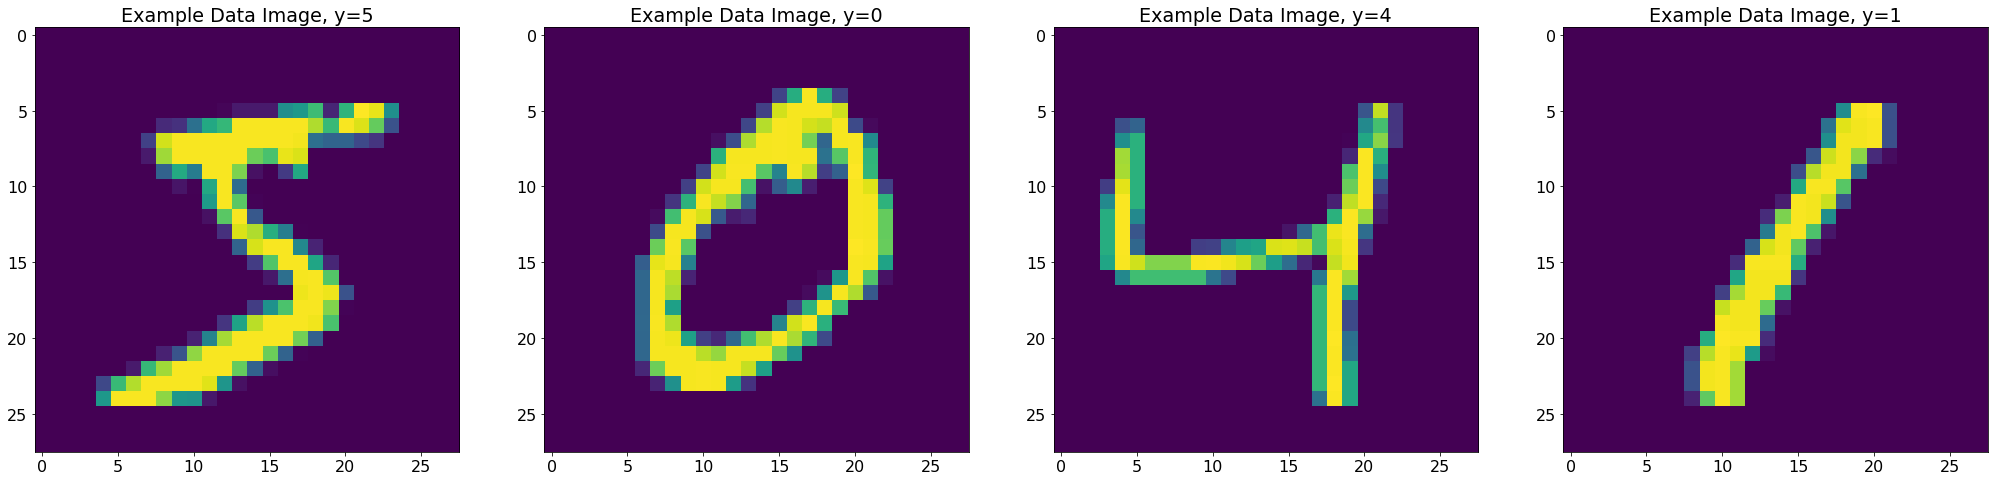

In [4]:
# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,4, figsize=(35,35))
imx, imy = (28,28)
labels   = [0,1,2,3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx,imy))
    ax.set_title("Example Data Image, y="+str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=0, vmax=1)
plt.show()

## Models

In [5]:
class VanillaVAE(nn.Module):
    def __init__(self, input_shape, z_dim):
        """
        Vanilla VAE Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Flattened size of image. (Default=784)
        z_dim : `int`
            The dimension of the latent variable z. (Default=20)
        """        
        super(VanillaVAE, self).__init__()
        self.input_shape = input_shape
        self.z_dim  = z_dim
        
        # build encoder
        self.encoder = nn.Sequential(nn.Linear(input_shape, 400),
                                     nn.ReLU(inplace=True))  
        self.fc_mu = nn.Linear(400, self.z_dim) 
        self.fc_log_var = nn.Linear(400, self.z_dim)
        
        # build decoder
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, 400),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(400, input_shape))          

    def encode(self, x):
        """
        x : [batch_size,784]
        """
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_log_var(x)
    
    def decode(self, z):
        """
        z : [batch_size,z_dim]
        """        
        return torch.sigmoid(self.decoder(z))
    
    def reparameterise(self, mu, log_var):
        """
        mu : [batch_size,z_dim]
        log_var : [batch_size,z_dim]        
        """        
        # get standard deviation
        std = torch.exp(0.5*log_var)
        # get epsilon from standard normal
        eps = torch.randn_like(std)
        return mu + std*eps
    
    def forward(self, x):
        """
        Forward pass 
        
        Parameters:
        -----------
        x : [batch_size,28,28]
        """
        # flattent image
        x_flat = x.view(x.size(0), -1)
        mu, log_var = self.encode(x_flat)
        z = self.reparameterise(mu, log_var)
        return self.decode(z), mu, log_var

## Training

In [6]:
# Hyperparameters
z_dim  = 20
epochs = 200
batch_size = 128
learning_rate = 1e-3

In [7]:
# Create DatatLoader 
dataset    = data_utils.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

# Loss function: Binary Cross Entropy Loss (BCE) + KL divergence
def loss_function(recon_x, x, mu, log_var):
    """
    Returns loss (mean)
    
    recon_x : [batch_size,784]
    x : [batch_size,28,28]    
    mu : [batch_size,z_dim]  
    log_var: [batch_size,z_dim] 
    """   
    BCE = F.binary_cross_entropy(recon_x, x.view(x.size(0), -1), reduction='sum')
    KL  = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - log_var - 1)
    return (KL + BCE) / x.size(0)

# Initialize VAE
vae = VanillaVAE(np.prod(x_train[0].shape), z_dim)

# Optimisers
optimiser = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Send to GPU if available
vae.to(device)

print("Device: ", device)
print(vae)

Device:  cpu
VanillaVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_log_var): Linear(in_features=400, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=784, bias=True)
  )
)


In [8]:
# Training
measures = defaultdict(list)
start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    
    # put VAE into train mode 
    vae.train()       
    
    batch_loss = 0
    for _, (X,_) in enumerate(dataloader): 
        X = X.to(device)
            
        # Zero accumulated gradients
        vae.zero_grad()
        
        # forward pass through VAE
        recon_batch, mu, log_var = vae(X)
        
        # Calculate loss
        loss = loss_function(recon_batch, X, mu, log_var)
        # Backpropogation: calculating gradients
        loss.backward()
        # Update parameters of generator
        optimiser.step()  
        
        # Save loss per batch
        batch_loss += loss.item()*X.size(0)                  
           
    # Save losses per epoch
    measures['total_loss'].append(batch_loss / len(dataloader.dataset))    
    
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "Loss: {:.4f}...".format(measures['total_loss'][-1]),
          "Time Taken: {:,.4f} seconds".format(time.time()-epoch_start_time))
    
    break
    
print("Total Time Taken: {:,.4f} seconds".format(time.time()-start_time))

Epoch: 1/200... Loss: 165.3149... Time Taken: 6.4759 seconds
Total Time Taken: 6.4765 seconds


## Results

In [9]:
#     # Save images produced every epoch
#     if epoch==0 or (epoch+1)%4==0:
#         indices = np.random.randint(0,X.size(0),n_classes)
#         measures['images'].append(gen_X[indices].detach().cpu().numpy())  

# # Plot images generated by decoder
# plt.rcParams.update({'font.size': 10})
# imx, imy = (28,28)
# for i, imgs in enumerate(measures['images']):
#     fig, axs = plt.subplots(1, n_classes, figsize=(20,2)) 
#     for j, img in enumerate(imgs):
#         visual = np.reshape(img, (imx,imy))
#         axs[j].imshow(visual)
#         axs[j].axis('off')
#     label = i+1 if i==0 else 4*i
#     plt.suptitle('Images after epoch: %s' %label)
#     plt.show()